83/83 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step


C:\Users\thebe\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 17s 58ms/step - accuracy: 0.7632 - loss: 7.1395 - val_accuracy: 0.8571 - val_loss: 5.1272 - learning_rate: 0.0010
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.8776 - loss: 4.6682 - val_accuracy: 0.8842 - val_loss: 3.2342 - learning_rate: 0.0010
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9083 - loss: 2.8517 - val_accuracy: 0.8827 - val_loss: 2.1077 - learning_rate: 0.0010
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9271 - loss: 1.8338 - val_accuracy: 0.8707 - val_loss: 1.6385 - learning_rate: 0.0010
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.9354 - loss: 1.4095 - val_accuracy: 0.8812 - val_loss: 1.3517 - learning_rate: 0.0010
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9255 - loss: 1.1824 - val_accuracy: 0.8932 - val_loss: 1.1761 - learning_rate: 0.0010
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9387 - loss: 0

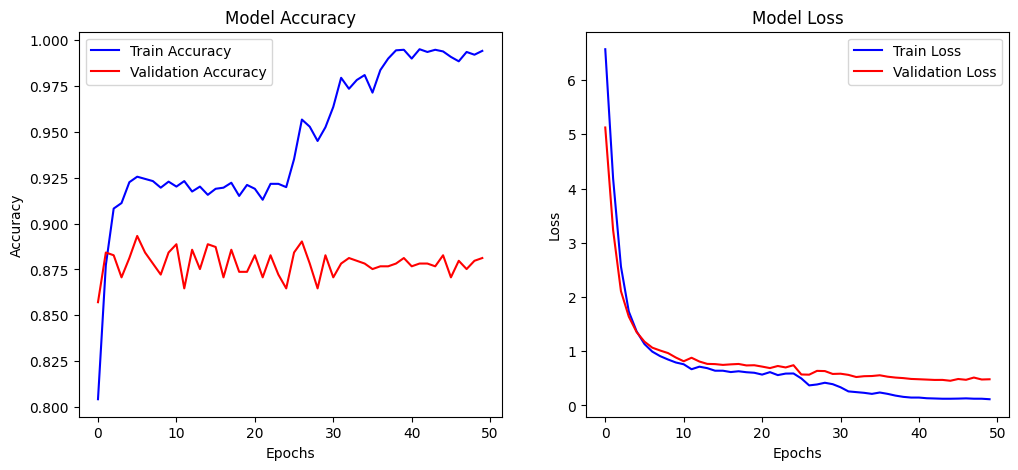

NameError: name 'explastiner' is not defined

In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from imblearn.over_sampling import SMOTE
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import lime
from lime.lime_tabular import LimeTabularExplainer

# Data Loading with Augmentation
base_path = '../Database/'
data, labels = [], []

data_gen = ImageDataGenerator(
    rotation_range=30, width_shift_range=0.2, height_shift_range=0.2,
    shear_range=0.2, zoom_range=0.2, horizontal_flip=True,
    brightness_range=[0.8, 1.2], fill_mode='nearest'
)

# Load Data
def load_images_from_folder(folder, label):
    folder_path = os.path.join(base_path, folder)
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        img = cv2.resize(img, (128, 128))
        data.append(img)
        labels.append(label)

load_images_from_folder("Normal", "Normal")
for folder in ["Lung_Opacity", "Viral Pneumonia"]:
    load_images_from_folder(folder, "Lung_Disease")

data = np.array(data).astype('float32') / 255.0
labels = np.array(labels)

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    data, labels_encoded, test_size=0.2, random_state=42, stratify=labels_encoded
)

# Extract HOG Features
def extract_hog_features(images):
    return np.array([hog(img, orientations=9, pixels_per_cell=(8, 8),
                          cells_per_block=(2, 2), visualize=False) for img in images])

X_train_hog = extract_hog_features(X_train)
X_test_hog = extract_hog_features(X_test)

# CNN Feature Extraction (ResNet50)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

x = GlobalAveragePooling2D()(base_model.output)
x = BatchNormalization()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)

feature_extractor = Model(inputs=base_model.input, outputs=x)

def extract_cnn_features(images):
    images = np.repeat(images[..., np.newaxis], 3, axis=-1)
    return feature_extractor.predict(images)

X_train_cnn = extract_cnn_features(X_train)
X_test_cnn = extract_cnn_features(X_test)

# Combine CNN + HOG Features
X_train_features = np.hstack((X_train_cnn, X_train_hog))
X_test_features = np.hstack((X_test_cnn, X_test_hog))

# Handle Imbalance Using SMOTE
smote = SMOTE(random_state=42)
X_train_features, y_train = smote.fit_resample(X_train_features, y_train)

# Feature Scaling
scaler = StandardScaler()
X_train_features = scaler.fit_transform(X_train_features)
X_test_features = scaler.transform(X_test_features)

# Model Training
model = tf.keras.Sequential([
    Dense(256, activation='relu', kernel_regularizer=l2(0.01), input_shape=(X_train_features.shape[1],)),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Learning Rate Scheduler & Early Stopping
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train_features, y_train, validation_data=(X_test_features, y_test),
                    epochs=50, callbacks=[lr_scheduler, early_stopping])

# Evaluation
y_pred = (model.predict(X_test_features) > 0.5).astype("int32")
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

plot_training_history(history)

# Modify LIME explanation
explainer = LimeTabularExplainer(
    X_train_features,
    feature_names=["Feature " + str(i) for i in range(X_train_features.shape[1])],
    class_names=["Normal", "Lung_Disease"],
    discretize_continuous=True
)

# Function to make LIME-compatible predictions
def lime_predict_fn(x):
    preds = model.predict(x)  # Model returns shape (n_samples, 1)
    return np.hstack([1 - preds, preds])  # Convert to shape (n_samples, 2)

# Explain a test instance
exp = explainer.explain_instance(X_test_features[0], lime_predict_fn, num_features=10)

# Show explanation
exp.as_pyplot_figure()
plt.show()
# Plot Training & Validation Graphs

